# Gaussian Mixture Models (GMMs) Clustering for Team Formations

In this notebook, we explore the use of Gaussian Mixture models to create homogeneous clusters of participants with similar attributes/features and then use a round-robin algorithm to form truly heterogeneous teams for a hackathon competition. The dataset has sensitive personal data like names and email addresses so we will mask this part of the data with fake generated ones using the `Faker` module.

In [1]:
# Import the dependencies
# Vectorized operations
import numpy as np
import pandas as pd

# Data manipulation
from collections import defaultdict
from faker import Faker
import re
import random

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

# Machine learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score
from sklearn.utils import shuffle

## Data Loading & Initial Inspection

In [2]:
original_df = pd.read_csv("../data/dh_responses.csv")
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 8 columns):
 #   Column                                                                                                                     Non-Null Count  Dtype 
---  ------                                                                                                                     --------------  ----- 
 0   Timestamp                                                                                                                  408 non-null    object
 1   Email address                                                                                                              408 non-null    object
 2   First name                                                                                                                 408 non-null    object
 3   Last name                                                                                                                  408 non-null 

In [3]:
original_df["What course are you pursuing?"].unique()

array(['Data Science', 'Data Analytics', 'Other', 'Data science'],
      dtype=object)

In [4]:
original_df["Which cohort do you belong to?"].unique().shape

(77,)

In [5]:
original_df["Which cohort do you belong to?"].unique()[:5]

array(['Cohort 2', 'C5', 'Cohort 7', 'Cohort 3', 'cohort 6'], dtype=object)

The initial inspection reveals **400+** records of applicants for a hackathon competition each with **8** variables. We will take the steps below to clean and anonymise sensitive data:

- Rename the columns of the original dataset.
- Lower the case of the text in the `gender` and `course` features.
- Use regular expressions to extract the cohort numbers to standardise the applicants' cohorts.
- Adjust errornous `cohort`s for accurate analysis.
- Get applicants' affiliation with the institution (ALX).
- Anonymise personal data in the dataset

## Data Cleaning & Transformation

In [6]:
def extract_cohort(input_string):
    """Regex pattern to extract cohort numbers"""
    pattern = re.compile(
        r"\d+|alumni|completed|pathway|aice|just started|not (?:yet(?: enrolled)?|sure)|i haven't been allocated one yet|software engineering|i don't know|front end web development|i am new",
        re.IGNORECASE,
    )

    # match the regex pattern in the string
    match = re.search(pattern, input_string)

    if match:
        if (
            (match.group().lower() == "alumni")
            or (match.group().lower() == "completed")
            or (match.group().lower() == "not yet")
            or (match.group().lower() == "not sure")
            or (match.group().lower() == "just started")
            or (match.group().lower() == "i haven't been allocated one yet")
            or (match.group().lower() == "pathway")
            or (match.group().lower() == "aice")
            or (match.group().lower() == "software engineering")
            or (match.group().lower() == "i don't know")
            or (match.group().lower() == "front end web development")
            or (match.group().lower() == "i am new")
        ): # Generic patterns
            return 0
        elif match.group().lower() == "not yet enrolled":  # Very specific pattern
            return np.NaN
        else:
            return int(match.group())
    else:
        return np.NaN

In [7]:
def clean_data(file_path):
    """Clean the dataset"""
    # Import the data from the .csv file
    df = pd.read_csv(file_path)  # "../data/dh_responses.csv"

    # Rename the columns
    df = df.rename(
        columns={
            "What course are you pursuing?": "course",
            "Which cohort do you belong to?": "cohort",
            "On a scale of  1 to 5 (1 being very unlikley and 5 being very likely), How likely are you to see this through to the end?": "cc_index", # confidence completion index on a scale of 1 to 5
        }
    )

    # lower the case of text in gender and course columns
    df["gender"] = df["gender"].str.lower()
    df["course"] = df["course"].str.lower()

    # Extract the cohort
    df["cohort"] = df["cohort"].astype(str).str.strip().apply(extract_cohort)

    # Adjust da and ds cohorts greater than (latest cohorts)
    # latest ds cohort: 3
    # latest da cohort: 8
    df.loc[(df["course"] == "data science") & (df["cohort"] > 3), "cohort"] = 3
    df.loc[(df["course"] == "data analytics") & (df["cohort"] > 8), "cohort"] = 8

    # Add affiliation column to the dataframe
    df["alx_affiliated"] = df["cohort"].apply(
        lambda x: "Affiliated" if pd.notnull(x) else "Not affiliated"
    )

    return df

In [8]:
# Initialize Faker with a seed for reproducibility
fake = Faker()
Faker.seed(42)

# Generate random first names taking gender into account
def fake_first_name(gender):
    if gender.lower() == "male":
        return fake.first_name_male()
    else:
        return fake.first_name_female()

# Generate random last names
def fake_last_name():
    return fake.last_name()

# Generate random email addresses
def fake_email_address(first_name, last_name):
    # concatenate the first and last names
    full_name = f"{first_name.lower()}{last_name.lower()}"
    
    # Concatenate string of random numbers
    number_counts = random.choice([0, 2, 3, 4])
    numbers = [str(random.choice(range(10))) for _ in range(number_counts)]
    num_str = "".join(numbers)
    local_part = f"{full_name}{num_str}"
    
    # Concatenate a random choice of domains to the local part
    domains = ["example.com", "institution.edu", "corporation.org"]
    email_address = f"{local_part}@{random.choice(domains)}"
    
    return email_address

In [9]:
# Get the original file path
orig_file_path = "../data/dh_responses.csv"

# Clean the data
clean_df = clean_data(orig_file_path)
clean_df.shape

(408, 9)

In [10]:
# Apply transformations
clean_df['First name'] = clean_df['gender'].apply(fake_first_name)
clean_df['Last name'] = clean_df['Last name'].apply(lambda x: fake_last_name())

# Generate emails based on the *new* names
clean_df['Email address'] = clean_df.apply(
    lambda row: fake_email_address(row['First name'], row['Last name']),
    axis=1
)

clean_df.head()

,Timestamp,Email address,First name,Last name,gender,course,cohort,cc_index,alx_affiliated
0,01/03/2025 19:11:33,markschultz700@example.com,Mark,Schultz,male,data science,2.0,5,Affiliated
1,01/03/2025 19:12:02,allisonrogers784@example.com,Allison,Rogers,female,data science,3.0,5,Affiliated
2,01/03/2025 19:12:03,denisecardenas@corporation.org,Denise,Cardenas,female,data analytics,7.0,5,Affiliated
3,01/03/2025 19:12:05,danielpotter886@corporation.org,Daniel,Potter,male,data science,2.0,5,Affiliated
4,01/03/2025 19:12:23,noahchambers47@corporation.org,Noah,Chambers,male,data science,2.0,4,Affiliated


We now have a cleaned and consistently structured dataset with anonymised dummy data.

## Dictionaries implementation

In this section of the notebook, we try a more direct implementation using dictionaries to group participants into teams. We'll compare this implementation to the clustering implementation.

In [11]:
# Shuffle the dataset to mix participants
df_shuffled = clean_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Group the participants by course
grouped_by_course = defaultdict(list)
for _, row in df_shuffled.iterrows():
    grouped_by_course[row["course"]].append(row)

print(type(grouped_by_course))

<class 'collections.defaultdict'>


In [12]:
# for k, v in grouped_by_course.items():
#     if k = "data science":
#         print(
#     print(i)

type(grouped_by_course["data science"][0])

pandas.core.series.Series

In [13]:
# Inspect the data science students in the data
clean_df["course"].value_counts()

course
data science      216
data analytics    102
other              90
Name: count, dtype: int64

In [14]:
list(clean_df["course"].unique())

['data science', 'data analytics', 'other']

In [15]:
# Create groups with diverse course representation
group_size = 5

In [16]:
def populate_teams(course_groups, team_size):
    # Initialize 
    teams = []
    current_team = []
    while any(course_groups.values()):
        for course in list(clean_df["course"].unique()):
            if course_groups[course]:  # If there are members left in this course
                current_team.append(course_groups[course].pop(0))
    
            if len(current_team) == team_size:
                teams.append(current_team)
                current_team = []
    
    # If any remaining members are left, add them to the last group
    if current_team:
        teams.append(current_team)

    # Convert teams data into DataFrames and return a dicionary of team DataFrames
    return {f"Group {i+1}": pd.DataFrame(teams) for i, team in enumerate(teams)}

In [17]:
formed_teams = populate_teams(grouped_by_course, 5)
# print(type(formed_teams))
len(formed_teams)

82

In [18]:
for team in list(formed_teams.keys())[:5]:
    print(team)

Group 1
Group 2
Group 3
Group 4
Group 5


## Clustering implementation

### Proficiency Approximation

We first try to approximate the level of proficiency of an applicant based on the duration between their course completion and datathon registration deadline dates. The following are assumptions we're making for the approximations:

- If an applicant has not completed their course by the registration deadline i.e. the date for their course completion is later/greater than the registration deadline, then they are assumed to be a novice/intermediate participant depending on the degree of deviation from the registration deadline.
- If an applicant has completed their course by the registration deadline i.e. the date for their course completion is equivalent to, ealier/less than the registration deadline, then they are assumed to be proficient

For experimentation purposes, we will extract the dates and days from the timestamp in the dataset, visualize the distribution of the days in the dataset and use either the median or the mean, *depending on the shape of the distribution*, as the application deadline and the dates as the course completion dates and use the duration between the two to create an estimated proficiency of the applicant. 

We also use the days as the scale because the applications took place in short time frame but in the real application, the duration will be calculated in months.

In [19]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       408 non-null    object 
 1   Email address   408 non-null    object 
 2   First name      408 non-null    object 
 3   Last name       408 non-null    object 
 4   gender          408 non-null    object 
 5   course          408 non-null    object 
 6   cohort          361 non-null    float64
 7   cc_index        408 non-null    int64  
 8   alx_affiliated  408 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 28.8+ KB


In [20]:
clean_df["Timestamp"].tail()

403    17/03/2025 10:23:55
404    18/03/2025 10:23:55
405    18/03/2025 17:45:08
406    19/03/2025 15:45:08
407    19/03/2025 16:45:08
Name: Timestamp, dtype: object

In [21]:
# Extract the date from the timestamp column
clean_df["date"] = pd.to_datetime(clean_df["Timestamp"], format="%d/%m/%Y %H:%M:%S").dt.date

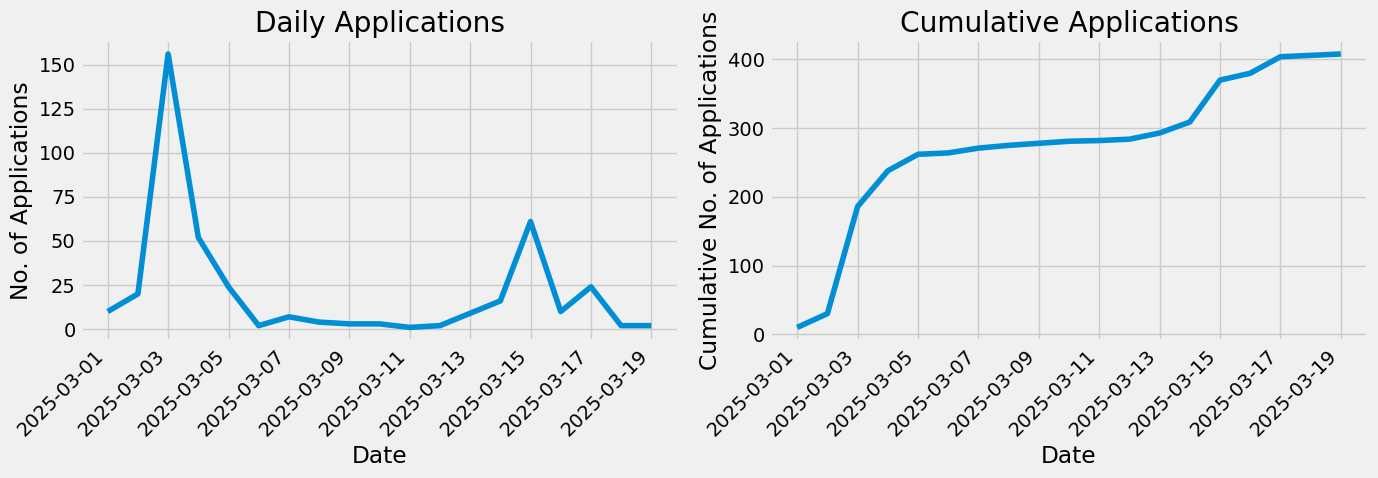

In [22]:
# Get the date counts
date_counts = clean_df["date"].value_counts().sort_index()
cumulative_counts = date_counts.cumsum()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot daily applications
ax1.plot(date_counts.index, date_counts.values)
ax1.set_title("Daily Applications")
ax1.set_xlabel("Date")
ax1.set_ylabel("No. of Applications")
ax1.tick_params(axis='x', rotation=45)
for label in ax1.get_xticklabels():
    label.set_ha('right')  # Set horizontal alignment separately

# Plot cumulative applications
ax2.plot(cumulative_counts.index, cumulative_counts.values)
ax2.set_title("Cumulative Applications")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative No. of Applications")
ax2.tick_params(axis='x', rotation=45)
for label in ax2.get_xticklabels():
    label.set_ha('right')  # Set horizontal alignment separately

# Adjust layout and display
plt.tight_layout()
plt.show()

In [23]:
# Extract the days from the timestamp
days = pd.to_datetime(clean_df["Timestamp"], format="%d/%m/%Y %H:%M:%S").dt.day
days.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19], dtype=int32)

In [24]:
# Import seaborn
import seaborn as sns

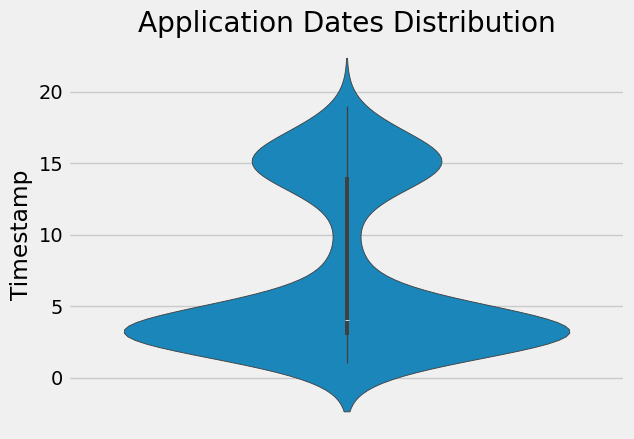

In [25]:
# Create a violin plot of the days distributions
sns.violinplot(data=days)
plt.title("Application Dates Distribution")
plt.show()

In [26]:
import statistics
# Compute the median day and use it as the registration deadline
statistics.median(days)

4.0

In [27]:
clean_df["date"].head()

0    2025-03-01
1    2025-03-01
2    2025-03-01
3    2025-03-01
4    2025-03-01
Name: date, dtype: object

In [28]:
type(clean_df.loc[0, "date"])

datetime.date

In [29]:
registration_deadline = pd.to_datetime("2025-03-04") # from the median day

# Estimate applicant's proficiency and create a new feature
clean_df["proficiency"] = clean_df["date"].apply(
    lambda x: "Novice" if (registration_deadline - pd.to_datetime(x)).days >= 0 else "Proficient")
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       408 non-null    object 
 1   Email address   408 non-null    object 
 2   First name      408 non-null    object 
 3   Last name       408 non-null    object 
 4   gender          408 non-null    object 
 5   course          408 non-null    object 
 6   cohort          361 non-null    float64
 7   cc_index        408 non-null    int64  
 8   alx_affiliated  408 non-null    object 
 9   date            408 non-null    object 
 10  proficiency     408 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 35.2+ KB


In [30]:
clean_df.head()

,Timestamp,Email address,First name,Last name,gender,course,cohort,cc_index,alx_affiliated,date,proficiency
0,01/03/2025 19:11:33,markschultz700@example.com,Mark,Schultz,male,data science,2.0,5,Affiliated,2025-03-01,Novice
1,01/03/2025 19:12:02,allisonrogers784@example.com,Allison,Rogers,female,data science,3.0,5,Affiliated,2025-03-01,Novice
2,01/03/2025 19:12:03,denisecardenas@corporation.org,Denise,Cardenas,female,data analytics,7.0,5,Affiliated,2025-03-01,Novice
3,01/03/2025 19:12:05,danielpotter886@corporation.org,Daniel,Potter,male,data science,2.0,5,Affiliated,2025-03-01,Novice
4,01/03/2025 19:12:23,noahchambers47@corporation.org,Noah,Chambers,male,data science,2.0,4,Affiliated,2025-03-01,Novice


In [31]:
clean_df["proficiency"].unique()

array(['Novice', 'Proficient'], dtype=object)

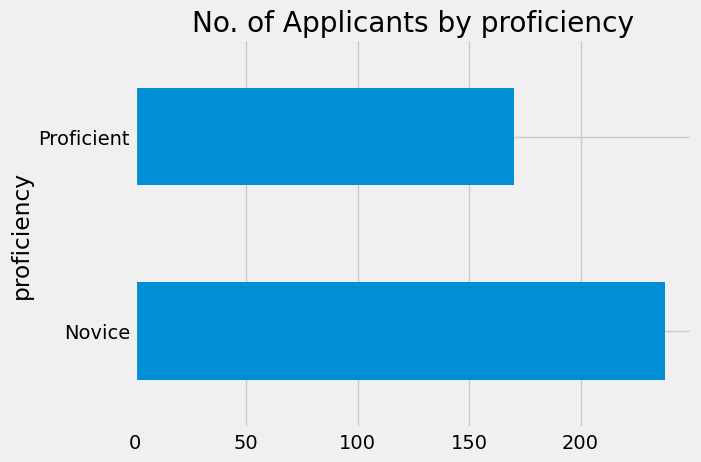

In [32]:
# Visualize the distribution of novice and proficient applicants
clean_df["proficiency"].value_counts().plot.barh()
plt.title("No. of Applicants by proficiency")
plt.show()

In [33]:
clean_df.head()

,Timestamp,Email address,First name,Last name,gender,course,cohort,cc_index,alx_affiliated,date,proficiency
0,01/03/2025 19:11:33,markschultz700@example.com,Mark,Schultz,male,data science,2.0,5,Affiliated,2025-03-01,Novice
1,01/03/2025 19:12:02,allisonrogers784@example.com,Allison,Rogers,female,data science,3.0,5,Affiliated,2025-03-01,Novice
2,01/03/2025 19:12:03,denisecardenas@corporation.org,Denise,Cardenas,female,data analytics,7.0,5,Affiliated,2025-03-01,Novice
3,01/03/2025 19:12:05,danielpotter886@corporation.org,Daniel,Potter,male,data science,2.0,5,Affiliated,2025-03-01,Novice
4,01/03/2025 19:12:23,noahchambers47@corporation.org,Noah,Chambers,male,data science,2.0,4,Affiliated,2025-03-01,Novice


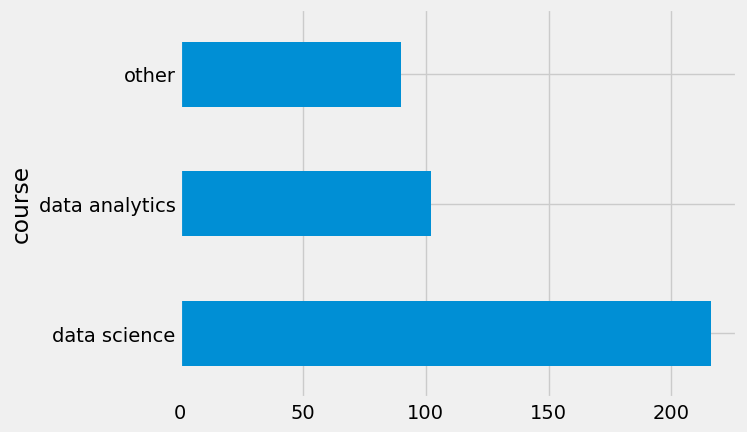

In [34]:
clean_df["course"].value_counts().plot.barh()
plt.show()

In [35]:
# Randomly impute courses labeled as other with either front-end or back-end
import random
clean_df["course"] = clean_df["course"].apply(
    lambda x: random.choice(["front-end wd", "back-end wd"]) if x == "other" else x)

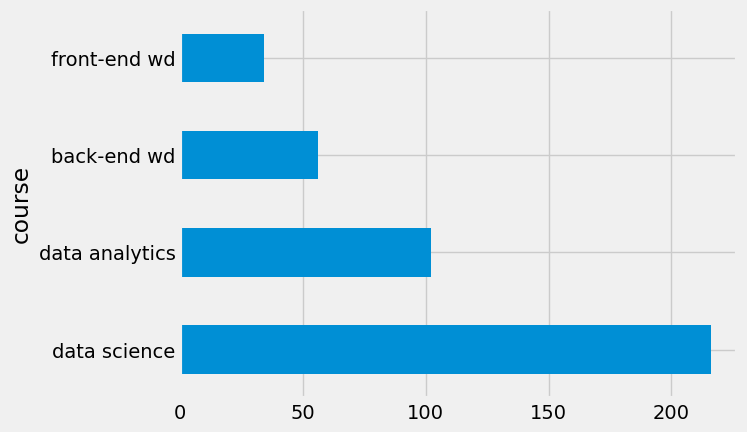

In [36]:
clean_df["course"].value_counts().plot.barh()
plt.show()

In [37]:
clean_df.columns

Index(['Timestamp', 'Email address', 'First name', 'Last name', 'gender',
       'course', 'cohort', 'cc_index', 'alx_affiliated', 'date',
       'proficiency'],
      dtype='object')

In [38]:
# Extract columns to retain in the final dataset
columns_to_keep = ["Email address", "First name", "Last name", "gender", "course", "alx_affiliated", "proficiency"]
clean_df = clean_df[columns_to_keep]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Email address   408 non-null    object
 1   First name      408 non-null    object
 2   Last name       408 non-null    object
 3   gender          408 non-null    object
 4   course          408 non-null    object
 5   alx_affiliated  408 non-null    object
 6   proficiency     408 non-null    object
dtypes: object(7)
memory usage: 22.4+ KB


In [39]:
clean_df.head()

,Email address,First name,Last name,gender,course,alx_affiliated,proficiency
0,markschultz700@example.com,Mark,Schultz,male,data science,Affiliated,Novice
1,allisonrogers784@example.com,Allison,Rogers,female,data science,Affiliated,Novice
2,denisecardenas@corporation.org,Denise,Cardenas,female,data analytics,Affiliated,Novice
3,danielpotter886@corporation.org,Daniel,Potter,male,data science,Affiliated,Novice
4,noahchambers47@corporation.org,Noah,Chambers,male,data science,Affiliated,Novice


In [40]:
# Drop the affiliated column and select participant descriptive features only
data = clean_df.drop("alx_affiliated", axis=1).loc[:, "gender":]

In [41]:
# One-hot encode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data)

# Evaluate clustering quality using Calinski-Harabasz Index for different k
k_range = range(2, 11)
ch_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(encoded_features.toarray())
    score = calinski_harabasz_score(encoded_features.toarray(), labels)
    ch_scores.append(score)

# Select best k and fit final GMM
best_k = k_range[np.argmax(ch_scores)]
best_score = max(ch_scores)

final_gmm = GaussianMixture(n_components=best_k, random_state=42)
final_clusters = final_gmm.fit_predict(encoded_features.toarray())
data['cluster'] = final_clusters

# Output the best k, best score, and cluster distribution
best_k, best_score, data['cluster'].value_counts().sort_index()

(10,
 324.9306846734008,
 cluster
 0    39
 1    58
 2    90
 3    34
 4    68
 5    36
 6    34
 7    14
 8    16
 9    19
 Name: count, dtype: int64)

In [42]:
# Inspect the clustered data points
data.head()

,gender,course,proficiency,cluster
0,male,data science,Novice,2
1,female,data science,Novice,4
2,female,data analytics,Novice,8
3,male,data science,Novice,2
4,male,data science,Novice,2


In [43]:
# Team Formation
min_team_size = 5
teams = []
participants_per_cluster = defaultdict(list)

# Group participants by cluster
for i, row in data.iterrows():
    participants_per_cluster[row['cluster']].append(i)

# Shuffle each cluster's participants
for cluster_id in participants_per_cluster:
    participants_per_cluster[cluster_id] = shuffle(participants_per_cluster[cluster_id], random_state=42)

# Total number of participants
total_participants = len(data)

# Estimate number of teams
estimated_teams = total_participants // min_team_size

# Distribute participants into teams ensuring cluster diversity
team_assignments = [[] for _ in range(estimated_teams)]

# Round-robin sampling from clusters into team slots
team_index = 0
while any(participants_per_cluster.values()):
    for cluster_id in range(k):
        if participants_per_cluster[cluster_id]:
            participant_id = participants_per_cluster[cluster_id].pop()
            team_assignments[team_index % estimated_teams].append(participant_id)
            team_index += 1

# Assign team IDs to participants
data['teamID'] = -1
for idx, team in enumerate(team_assignments):
    for participant_id in team:
        data.at[participant_id, 'teamID'] = idx + 1  # Team IDs start from 1

In [44]:
# Inspect assigned team IDs
data.head()

,gender,course,proficiency,cluster,teamID
0,male,data science,Novice,2,80
1,female,data science,Novice,4,33
2,female,data analytics,Novice,8,76
3,male,data science,Novice,2,42
4,male,data science,Novice,2,12


In [45]:
np.sort(data["teamID"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

In [46]:
data[data["teamID"] == 81]

,gender,course,proficiency,cluster,teamID
77,female,data science,Novice,4,81
163,female,data science,Novice,4,81
192,male,data science,Novice,2,81
261,female,data analytics,Proficient,3,81
300,male,back-end wd,Proficient,0,81


In [47]:
data[data["teamID"] == 1]

,gender,course,proficiency,cluster,teamID
70,female,data science,Novice,4,1
98,male,data analytics,Novice,5,1
150,male,data science,Novice,2,1
299,male,data science,Proficient,1,1
325,male,data science,Proficient,1,1
402,male,back-end wd,Proficient,0,1


In [48]:
personal_inf = clean_df[["Email address", "First name", "Last name"]]
personal_inf.head()

,Email address,First name,Last name
0,markschultz700@example.com,Mark,Schultz
1,allisonrogers784@example.com,Allison,Rogers
2,denisecardenas@corporation.org,Denise,Cardenas
3,danielpotter886@corporation.org,Daniel,Potter
4,noahchambers47@corporation.org,Noah,Chambers


In [49]:
personal_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Email address  408 non-null    object
 1   First name     408 non-null    object
 2   Last name      408 non-null    object
dtypes: object(3)
memory usage: 9.7+ KB


In [50]:
grouped_df = pd.merge(personal_inf, data, left_index=True, right_index=True, how="inner")

grouped_df["teamID"].value_counts().sort_index(ascending=False)

teamID
81    5
80    5
79    5
78    5
77    5
     ..
5     5
4     5
3     6
2     6
1     6
Name: count, Length: 81, dtype: int64

In [51]:
grouped_df[grouped_df["teamID"] == 81]

,Email address,First name,Last name,gender,course,proficiency,cluster,teamID
77,judyashley2463@corporation.org,Judy,Ashley,female,data science,Novice,4,81
163,susangraham@example.com,Susan,Graham,female,data science,Novice,4,81
192,davidmiller764@example.com,David,Miller,male,data science,Novice,2,81
261,sherryhayes@example.com,Sherry,Hayes,female,data analytics,Proficient,3,81
300,stuartroberts67@institution.edu,Stuart,Roberts,male,back-end wd,Proficient,0,81


In [52]:
grouped_df = grouped_df.drop("cluster", axis="columns")

In [53]:
grouped_df.head()

,Email address,First name,Last name,gender,course,proficiency,teamID
0,markschultz700@example.com,Mark,Schultz,male,data science,Novice,80
1,allisonrogers784@example.com,Allison,Rogers,female,data science,Novice,33
2,denisecardenas@corporation.org,Denise,Cardenas,female,data analytics,Novice,76
3,danielpotter886@corporation.org,Daniel,Potter,male,data science,Novice,42
4,noahchambers47@corporation.org,Noah,Chambers,male,data science,Novice,12
